In [79]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from tqdm import tqdm
import mediapy as media
import jax
import numpy as np

In [80]:
#!ls -lt baselines

In [5]:
run_dir = Path('baselines/mini_agent_stats') # Path('baselines/session_ebdfe818')
# original session_e41c9eff, main session_4da05e87, extra session_e1b6d2dc

In [44]:
dfs = []
for run in tqdm(run_dir.glob('*.gz')):
    tdf = pd.read_csv(run, compression='gzip')
    dfs.append(tdf[tdf['map'] != 'map'])

5it [01:26, 17.29s/it]


In [81]:
def make_all_coords_arrays(filtered_dfs):
    return np.stack([tdf[['x', 'y', 'map']].to_numpy().astype(np.uint8) for tdf in filtered_dfs]).transpose(1,0,2)

In [82]:
def load_tex(name):
    resp = requests.get(sprites[name])
    return np.array(Image.open(io.BytesIO(resp.content)))

In [83]:
def get_sprite_by_coords(img, x, y):
    sy = 34+17*y
    sx = 9 +17*x
    alpha_v = np.array([255, 127,  39, 255], dtype=np.uint8)
    sprite = img[sy:sy+16, sx:sx+16]
    return np.where((sprite == alpha_v).all(axis=2).reshape(16,16,1), np.array([[[0,0,0,0]]]), sprite).astype(np.uint8)


In [585]:
def add_sprite(overlay_map, sprite, x, y, map_idx, 
               x_inter=0, y_inter=0, 
               opacity=1.0, add=True):
    global_offset = np.array([1062-16*24, 338]) #np.array([790, -29])
    map_offsets = {
        # https://bulbapedia.bulbagarden.net/wiki/List_of_locations_by_index_number_(Generation_I)
        0: np.array([0,0]), # pallet town
        1: np.array([-10, 72]), # viridian
        2: np.array([-10, 180]), # pewter
        12: np.array([0, 36]), # route 1
        13: np.array([0, 144]), # route 2
        37: np.array([9+12, 150-150]), # red house first
        38: np.array([16+12, 150-150]), # red house second
        39: np.array([9+12, 140-150]), # blues house
        40: np.array([25+12, 150-150]), # oaks lab
        51: np.array([22, 123]) # viridian forest
    }
    if map_idx in map_offsets.keys():
        offset = map_offsets[map_idx]
    else:
        offset = np.array([0,0])
        x, y = 0, 0
    coord = global_offset + 16*(offset + np.array([x,y])) + np.array([x_inter, y_inter])
    coord[1] = overlay_map.shape[0] - coord[1]
    if coord.max() > 4000:
        print(f'bad coord: {coord}')
        return
    raw_base = (overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :])
    if add:
        base = raw_base.astype(np.float32)
        new = opacity*sprite.astype(np.float32)
        intermediate = (base + new).clip(0, 255).astype(np.uint8)
    else:
        #print(f'requested coords: {coord[1]}-{coord[1]+16}, {coord[0]}-{coord[0]+16}')
        intermediate = raw_base
        mask = sprite[:, :, 3] != 0
        if (mask.shape != intermediate[:,:,0].shape):
            print(f'requested coords: {coord[1]}-{coord[1]+16}, {coord[0]}-{coord[0]+16}')
            print(f'overlay_map.shape {overlay_map.shape}')
            print(f'mask.shape {mask.shape} intermediate[:,:,0].shape {intermediate[:,:,0].shape}')
            print(f'x {x} y {y} map {map_idx}')
            #print(f'coord ({coord}) = {global_offset} + 16*{offset} + {np.array([x,y])}')
        intermediate[mask] = sprite[mask]
    overlay_map[coord[1]:coord[1]+16, coord[0]:coord[0]+16, :] = intermediate

In [539]:
def blend_overlay(background, over):
    al = over[...,3].reshape(over.shape[0], over.shape[1], 1)
    ba = (255-al)/255
    oa = al/255
    return (background[..., :3]*ba + over[..., :3]*oa).astype(np.uint8)

In [540]:
def render_coords(coords, over):
    for x,y,mp in coords:
        add_sprite(over, walks[0], int(x), -int(y), mp, add=False)

In [541]:
def split(img):
    return rearrange(img, '(s y) x c -> y (s x) c', s=2)

In [573]:
def render_video(all_coords, bg, inter_steps=4, fade_freq=1, fade_amt=1, add_frames=True):
    over = np.zeros_like(bg, dtype=np.uint8)
    debug = False
    with media.VideoWriter('test_out_short.mp4', split(bg[800:3970, 500:1600]).shape[:2], fps=60) as wr:
        step_count = len(all_coords)
        directions = [0] * len(all_coords[0])
        for idx in tqdm(range(1, step_count)):
            if idx % fade_freq == 0:
                over[over > 0] -= fade_amt
            step = all_coords[idx]
            prev_step = all_coords[idx-1]
            if debug:
                print('-- step --')
            inter_size = 16//inter_steps
            for inter_step in np.arange(inter_size, 16+inter_size, inter_size, dtype=np.int):
                for run in range(len(step)):
                    cur = step[run]
                    prev = prev_step[run]
                    # cast to regular int from uint8
                    cx, cy, px, py = map(int, [cur[0], cur[1], prev[0], prev[1]])
                    dx = min(max(cx - px, -1), 1)
                    dy = -1*min(max(cy - py, -1), 1)
                    if debug:
                        print(f'x: {cx} y: {cy} dx: {dx} dy: {dy}')
                    # only change direction if not moving between maps
                    if cur[2] == prev[2]:
                        if dx > 0:
                            directions[run] = 3
                        elif dx < 0:
                            directions[run] = 2
                        elif dy > 0:
                            directions[run] = 1
                        elif dy < 0:
                            directions[run] = 0
                    #print(f'uninterped x: {16*px+16*dx} y: {-16*py+16*dy}')
                    #inter_step = 0
                    add_sprite(over, walks[directions[run]], 
                               px, -py, 
                               cur[2], x_inter=inter_step*dx, y_inter=inter_step*dy, add=add_frames)
                wr.add_image(split(blend_overlay(bg[800:3970, 500:1600], over[800:3970, 500:1600])))
                

In [417]:
n = 4
sp_n = 16//n
np.arange(sp_n, 16+sp_n, sp_n, dtype=np.int)

array([ 4,  8, 12, 16])

In [361]:
#sprites = {
#    'characters': 'https://www.spriters-resource.com/resources/sheets/8/8728.png',
#    0: 'https://www.spriters-resource.com/resources/sheets/52/55181.png'
#}
main_map = np.array(Image.open('temp/RoughMap.png'))
chars_img = np.array(Image.open('sprites/characters.png'))
alpha_val = get_sprite_by_coords(chars_img, 1, 0)[0,0]
walks = [get_sprite_by_coords(chars_img, x, 0) for x in [1, 4, 6, 8]]

In [122]:
base_coords = make_all_coords_arrays(dfs)

In [131]:
base_coords.shape

(9994850, 5, 3)

In [267]:
# fold over some runs on top of each other
rearrange(base_coords, '(v s) r c -> s (r v) c', v=610).shape

(16385, 3050, 3)

In [567]:
start_bg = main_map.copy()*0
overlay = np.zeros_like(start, dtype=np.uint8)

In [ ]:
render_video(
    rearrange(base_coords, '(v s) r c -> s (r v) c', v=610)[0:5000],
    start_bg, inter_steps=8,
    fade_freq=1, fade_amt=10, add_frames=False
)


  0%|          | 8/4999 [00:22<3:52:10,  2.79s/it]

In [422]:
start_bg.shape

(4000, 4000, 4)

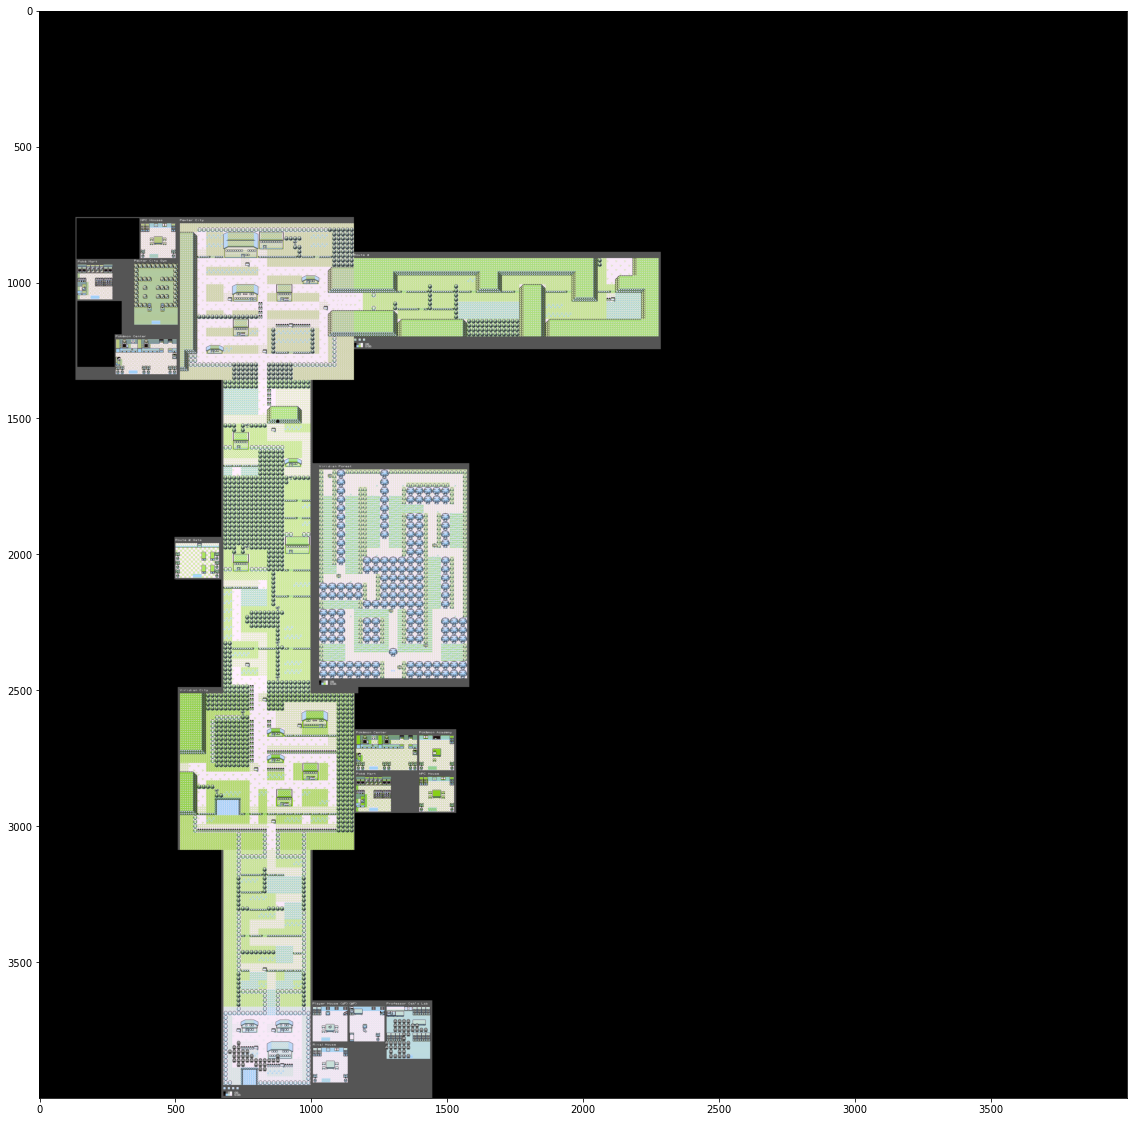

In [568]:
render_coords(base_coords[:500, 0], overlay)
plt.figure(figsize = (20,20))
img_full = blend_overlay(start, overlay)#[800:3970, 500:1600]
plt.imshow(img_full)

In [262]:
# find time spent holding each pokemon
all_poke_ids = {}
for df in dfs:
    for step in tqdm(df['ptypes']):
        pokes = json.loads(step)
        for p in pokes:
            if p in all_poke_ids.keys():
                all_poke_ids[p] += 1
            else:
                all_poke_ids[p] = 1

100%|██████████| 9994850/9994850 [00:42<00:00, 237251.67it/s]


In [263]:
all_poke_ids

{177: 37600592,
 255: 49327310,
 0: 95664853,
 165: 39991280,
 36: 54695513,
 179: 12356844,
 150: 676610,
 112: 561622,
 113: 209597,
 133: 8317692,
 169: 121749,
 107: 204188,
 109: 53943,
 100: 2672,
 84: 40934,
 124: 11724,
 4: 8377}

In [260]:
all_poke_ids

{177: 7628520,
 255: 9904852,
 0: 19292595,
 165: 7904615,
 36: 10716363,
 179: 2365574,
 150: 195766,
 112: 160814,
 113: 40083,
 133: 1671592,
 169: 17784,
 107: 69533,
 109: 1009}

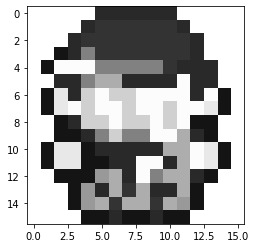

In [331]:
plt.imshow(walks[0]+walks[2])

In [343]:
cop = walks[1].copy()
mask = walks[2][:, :, 3] != 0
cop[mask] = walks[2][mask]

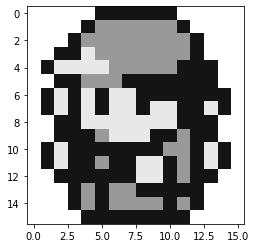

In [344]:
plt.imshow(cop)

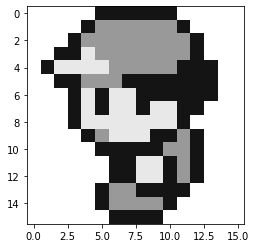

In [345]:
plt.imshow(walks[2])

In [350]:
walks[2][mask].shape

(138, 4)